<font size = 6 color = 'green'> CÁLCULO DE ANOMALÍAS DE TEMPERATURA SUPERFICIAL DEL MAR


<font size = 4> Elaborado por Kevin Campos Sánchez

<font size = 2> Si el material te fue de utilidad, por favor, considere darme los créditos por el trabajo c:

### <font color = 'green'> Preparación de entorno

In [4]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

##### CONFIGURACIÓN DE ENTORNO #####
from google.colab import drive     # Conectar Google drive
drive.mount('/content/drive/')

import os

path = '/content/drive/MyDrive/Trabajos_UNALM/I.O.A./P1_IOA/'  # Directorio de trabajo (cambiar aquí)
os.chdir(path)    # Seleccionar carpeta de trabajo

Mounted at /content/drive/


Descarga de librerías

In [5]:
%%capture
!pip install 'cartopy==0.18.0'
!pip install shapely --no-binary shapely --force
!pip install geopandas
!pip install 'xarray==0.19.0'
# !pip install rioxarray

### <font color = 'green'> Cálculo de climatología, anomalías y promedios en región

Lectura de datos

In [6]:
import xarray as xr, pandas as pd, numpy as np

sst = xr.open_dataset(path + 'HadISST_sst.nc', drop_variables = ['time_bnds'])  # https://www.metoffice.gov.uk/hadobs/hadsst4/
sst = xr.where(sst == -1000., np.nan, sst)                              # Filtrado de NaN = -1000.
sst['time'] = pd.date_range('1870-01-01', '2022-02-01', freq = 'M')     # Reemplazar time por un pandas.DateTimeIndex
sst

<xarray.Dataset>
Dimensions:    (time: 1825, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-31 1870-02-28 ... 2022-01-31
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan ... nan nan nan

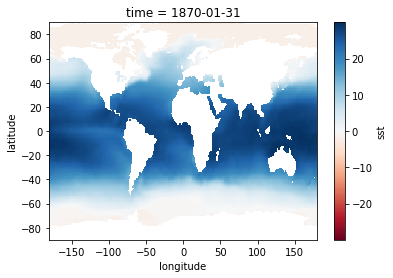

In [7]:
sst.sel(time = '1870-01-31T00:00:00.000000000').sst.plot(cmap = 'RdBu')     # Visualización básica

In [8]:
sst_clim = sst.sel(time = slice('1991-01-31T00:00:00.000000000','2020-12-31T00:00:00.000000000'))\
                .groupby('time.month').mean('time')     # Climatología 1991-2020
sst_clim

<xarray.Dataset>
Dimensions:    (month: 12, latitude: 180, longitude: 360)
Coordinates:
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst        (month, latitude, longitude) float32 -1.8 -1.8 -1.8 ... nan nan

In [9]:
sst_anom = sst.groupby('time.month') - sst_clim     # Anomalías
sst_anom

<xarray.Dataset>
Dimensions:    (time: 1825, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-31 1870-02-28 ... 2022-01-31
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12 1
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan ... nan nan nan

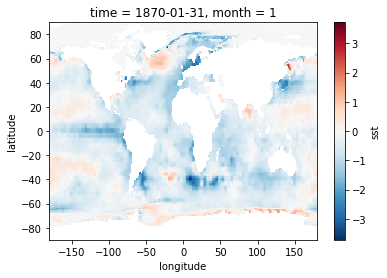

In [10]:
sst_anom.sel(time = '1870-01-31T00:00:00.000000000').sst.plot()

In [11]:
# Series de tiempo para regiones NIÑO
# https://www.ncei.noaa.gov/access/monitoring/enso/sst
N1_2 = {'min_lon': -90., 'max_lon':-80., 'min_lat':-10., 'max_lat':0.}  # Niño 1+2
N3   = {'min_lon': -150., 'max_lon':-90., 'min_lat':-5., 'max_lat':5.}  # Niño 3
N4   = {'min_lon': 160., 'max_lon':-150., 'min_lat':-5., 'max_lat':5.}  # Niño 4
N3_4 = {'min_lon': -170., 'max_lon':-120., 'min_lat':-5., 'max_lat':5.}  # Niño 3.4

def crop_region(ds, region_dict, x_name = 'longitude', y_name = 'latitude', nino_4 = False, drop = False):
    # Nota: xarray.DataArray identifica el orden horizontal y vertical de las coordenadas, los
    #       numpy.array no, por lo que al momento de intersectar lon_mask & lat_mask saltará error
    # ds_shape = (ds[x_name].size, ds[y_name].size)
    # lat = np.full(fill_value = ds[y_name].values, shape = ds_shape)
    # lon = np.full(fill_value = ds[x_name].values[:,np.newaxis], shape = ds_shape)
    # lon_mask = np.full(fill_value = False, shape = ds[x_name].size)
    # lat_mask = np.full(fill_value = False, shape = ds[y_name].size)

    for limit, val in region_dict.items():
        if limit == 'min_lon':      # min debe ser definido en region_dict antes del max
            lon_mask = (ds[x_name] >= val)
        elif limit == 'max_lon':
            if nino_4:  lon_mask = lon_mask | (ds[x_name] <= val) 
            else:       lon_mask = lon_mask & (ds[x_name] <= val)
            # Niño 4 requiere un tratamiento especial al tener límites longitudinales en el este y oeste
            # Pendiente: mejorar esta función para no tener que hacer esta diferencia
        elif limit == 'min_lat':
            lat_mask = (ds[y_name] >= val)
        elif limit == 'max_lat':
            lat_mask = lat_mask & (ds[y_name] <= val)
    ds = ds.where(lon_mask & lat_mask, drop = drop)
    return ds

sst_N1_2 = crop_region(ds = sst_anom, region_dict = N1_2, drop = True)
sst_N3 = crop_region(ds = sst_anom, region_dict = N3, drop = True)
sst_N4 = crop_region(ds = sst_anom, region_dict = N4, drop = True, nino_4 = True)
sst_N3_4 = crop_region(ds = sst_anom, region_dict = N3_4, drop = True)

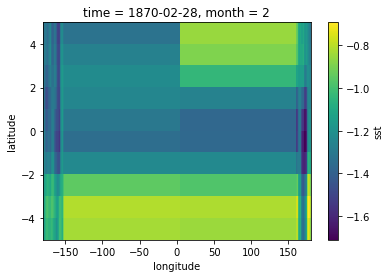

In [12]:
sst_N4.isel(time = 1).sst.plot()

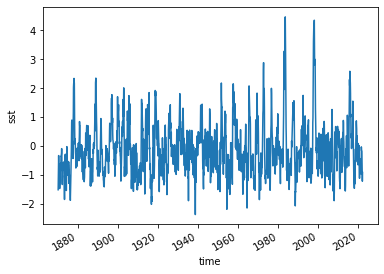

In [13]:
sst_N1_2.mean(['latitude','longitude']).sst.plot()  # Promedio en región ---> serie de tiempo

In [14]:
# DataFrame de las series temporales
N1_2 = sst_N1_2.mean(['latitude','longitude']).sst.values
N3 = sst_N3.mean(['latitude','longitude']).sst.values
N4 = sst_N4.mean(['latitude','longitude']).sst.values
N3_4 = sst_N3_4.mean(['latitude','longitude']).sst.values

dr = pd.date_range('1870-01-01', '2022-02-01', freq = 'M')
Anom_region = pd.DataFrame({'N1+2':N1_2, 'N3':N3,'N4':N4, 'N3.4':N3_4}, index = dr)
Anom_region

,N1+2,N3,N4,N3.4
1870-01-31,-1.499781,-1.357173,-0.529492,-1.016603
1870-02-28,-1.020477,-1.206481,-1.236421,-1.203682
1870-03-31,-0.646392,-0.775926,-1.095863,-0.843422
1870-04-30,-0.320151,-0.884886,-1.147727,-0.920434
1870-05-31,-0.716427,-1.218645,-1.215029,-1.359085
...,...,...,...,...
2021-09-30,-0.179493,-0.357514,-0.406391,-0.512183
2021-10-31,-0.528840,-0.647931,-0.558743,-0.830465
2021-11-30,-0.907722,-0.926966,-0.606526,-0.980604
2021-12-31,-1.204601,-1.153913,-0.704047,-1.121917


In [15]:
sst_season = sst.sel(time = slice('1991-01-31T00:00:00.000000000','2020-12-31T00:00:00.000000000'))\
                .groupby('time.season').mean('time')     # Climatología estacional 1991-2020
sst_season

<xarray.Dataset>
Dimensions:    (season: 4, latitude: 180, longitude: 360)
Coordinates:
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    sst        (season, latitude, longitude) float32 -1.8 -1.8 -1.8 ... nan nan

In [16]:
Anom_regionS = Anom_region.shift(1, freq = 'M').resample('Q').mean()        # Anomalías estacionales
# Desfazar el inicio un mes (empezará en febrero)
# Promedio trimestral supuesto (EFM, AMJ, JAS, OND), pues pandas los agrupa así
# Promedio trimestral real (DEF, MAM, JJA, SON), debido al desfase (maravillosa jugada)
Anom_regionS

,N1+2,N3,N4,N3.4
1870-03-31,-1.260129,-1.281827,-0.882957,-1.110143
1870-06-30,-0.560990,-0.959819,-1.152873,-1.040980
1870-09-30,-1.021293,-1.056182,-1.122089,-1.086050
1870-12-31,-1.237240,-1.053004,-0.632775,-0.799132
1871-03-31,-0.841869,-0.586405,-0.606107,-0.561774
...,...,...,...,...
2021-03-31,-0.685776,-0.798109,-0.855395,-1.004585
2021-06-30,-0.752901,-0.680024,-0.440556,-0.633420
2021-09-30,-0.109657,-0.259894,-0.233176,-0.301861
2021-12-31,-0.538685,-0.644137,-0.523887,-0.774417


In [ ]:
Anom_regionY = Anom_region.resample('Y').mean()     # Anomalías anuales
Anom_regionY

In [ ]:
Anom_region5Y = Anom_region.resample('5Y').mean()   # Promedio penta-anual (5 años)
Anom_region5Y

In [19]:
Anom_region10Y = Anom_region.resample('10Y').mean()   # Promedio deca-anual (10 años)
Anom_region10Y.head(5)

,N1+2,N3,N4,N3.4
1870-12-31,-1.011845,-1.062910,-0.935764,-0.986962
1880-12-31,-0.352642,-0.455151,-0.594496,-0.402935
1890-12-31,-0.220814,-0.339714,-0.384888,-0.273613
1900-12-31,0.006504,-0.226428,-0.505089,-0.254914
1910-12-31,-0.299485,-0.228957,-0.330686,-0.179482


### <font color = 'green'> Gráficos para el informe

In [20]:
import matplotlib.pyplot as plt, matplotlib.ticker as mticker,matplotlib.dates as mdates, cartopy.crs as ccrs
from cartopy.feature import BORDERS, OCEAN, LAND
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

projection = ccrs.PlateCarree()
mes = {1:'ENERO',2:'FEBRERO',3:'MARZO',4:'ABRIL',5:'MAYO',6:'JUNIO',
       7:'JULIO',8:'AGOSTO',9:'SETIEMBRE',10:'OCTUBRE',11:'NOVIEMBRE',12:'DICIEMBRE'}
season = {1:'Verano - DEF',2:'Otoño - MAM',3:'Invierno - JJA',4:'Primavera - SON'}

Climatología mensual 1991-2020 de SST - HadSST 4.0.1.0

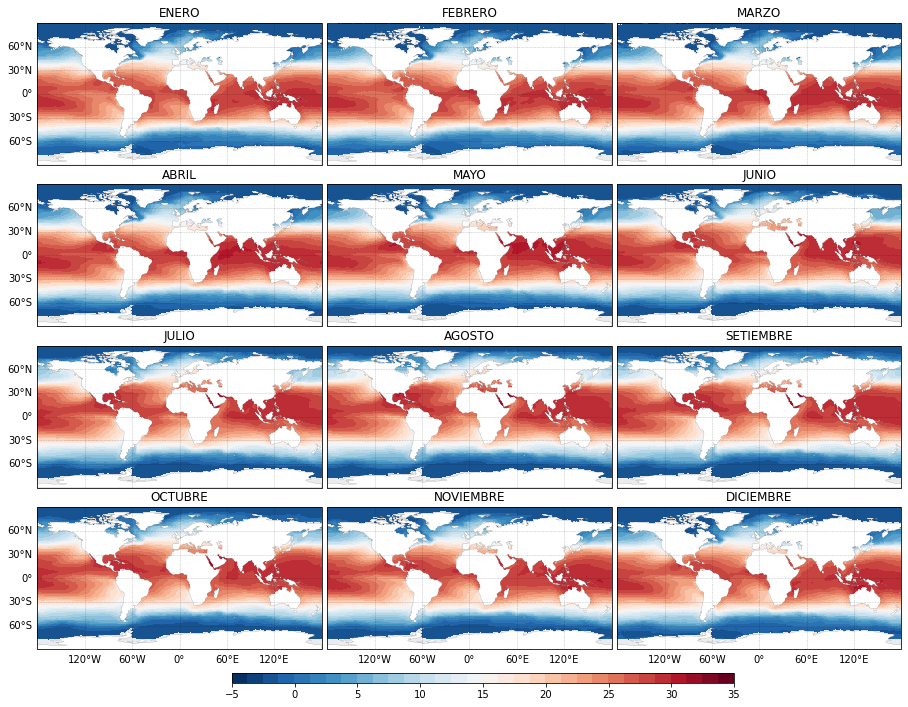

In [21]:
cmap = plt.get_cmap('RdBu_r', (35 - -5)/1.25)
cmap.set_bad('#EBEBEB')

plot = sst_clim.sst.plot(x='longitude', y='latitude', col='month', col_wrap=3, figsize = (15,15),   # Plot horizontal 3x3
                         subplot_kws = {"projection": projection}, 
                         cmap = cmap, vmin = -5, vmax = 35,
                         cbar_kwargs={'orientation':'horizontal', 'pad':0.05, 'shrink':0.6, 'aspect':50, 'label':''})

for i, ax in enumerate(plot.axes.flatten()):
    ax.add_feature(LAND, edgecolor='black', facecolor = 'white', lw = 0.1, zorder = 1)
    ax.set_title(mes[i+1])

    grids = ax.axes.gridlines(color='black', alpha=0.25, linestyle='--', linewidth = 0.5,
                                crs=ccrs.PlateCarree(),
                                draw_labels=True)

    grids.xlabels_top = False; grids.ylabels_right = False    # Desactivar labels innecesarios
    if i not in [0, 3, 6, 9]:  grids.ylabels_left = False
    if i not in [9, 10, 11]:  grids.xlabels_bottom = False

    grids.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120])  # labels x
    grids.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])    # labels y

    grids.xformatter = LONGITUDE_FORMATTER; grids.yformatter = LATITUDE_FORMATTER

plt.subplots_adjust(bottom = 0.26, top = 0.9, left = 0.1, right = 0.9, wspace = 0.02, hspace = -0.22)

plot.fig.savefig(path + f'SST_Climatology_1991-2020.png', 
                 transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

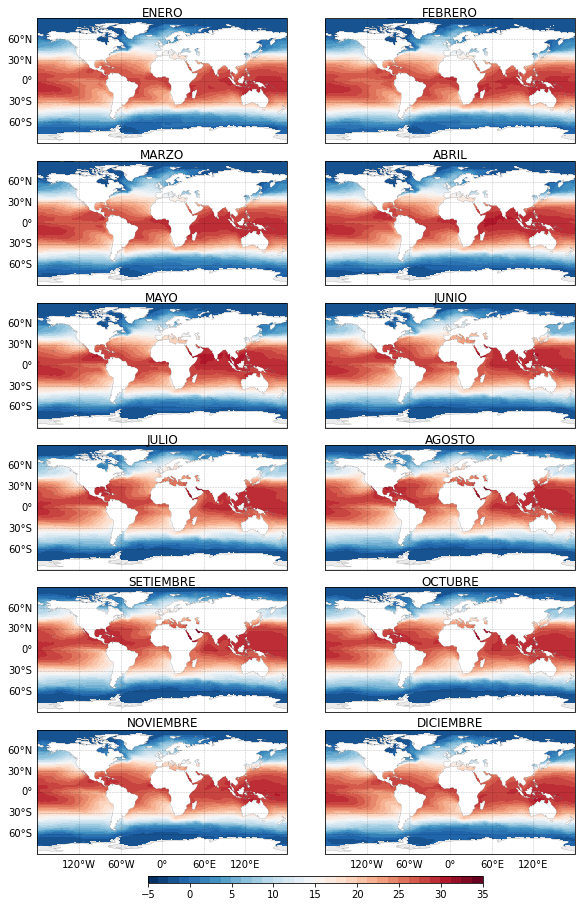

In [22]:
cmap = plt.get_cmap('RdBu_r', (35 - -5)/1.25)
cmap.set_bad('#EBEBEB')

plot = sst_clim.sst.plot(x='longitude', y='latitude', col='month', col_wrap=2, figsize = (10,18),   # Plot vertical 6x2
                         subplot_kws = {"projection": projection}, 
                         cmap = cmap, vmin = -5, vmax = 35,
                         cbar_kwargs={'orientation':'horizontal', 'pad':0.1, 'shrink':0.6, 'aspect':50, 'label':''})

for i, ax in enumerate(plot.axes.flatten()):
    ax.add_feature(LAND, edgecolor='black', facecolor = 'white', lw = 0.1, zorder = 1)
    ax.set_title(mes[i+1], pad = 1.75)

    grids = ax.axes.gridlines(color='black', alpha=0.25, linestyle='--', linewidth = 0.5,
                                crs=ccrs.PlateCarree(),
                                draw_labels=True)

    grids.xlabels_top = False; grids.ylabels_right = False    # Desactivar labels innecesarios
    if i not in [0, 2, 4, 6, 8, 10]:  grids.ylabels_left = False
    if i not in [10,11]:  grids.xlabels_bottom = False

    grids.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120])  # labels x
    grids.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])    # labels y

    grids.xformatter = LONGITUDE_FORMATTER; grids.yformatter = LATITUDE_FORMATTER

plt.subplots_adjust(bottom = 0.255, top = 0.9, left = 0.1, right = 0.9, wspace = 0.0, hspace = 0.14)

plot.fig.savefig(path + f'SST_Climatology_1991-2020v.png', 
                 transparent = False, pad_inches = 0.05, dpi = 600, bbox_inches = 'tight')

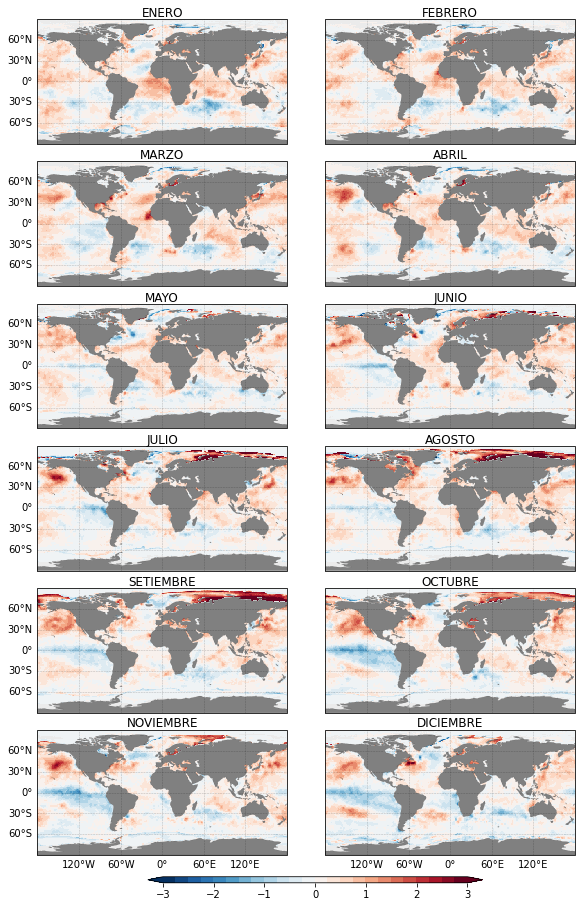

In [23]:
cmap = plt.get_cmap('RdBu_r', (3 - -3)/0.25)
cmap.set_bad('#EBEBEB')

year = 2020     # Seleccionar año
ds = sst_anom.sel(time = slice(f'{year}-01-31T00:00:00.000000000',f'{year}-12-31T00:00:00.000000000')).groupby('time.month').mean()

plot = ds.sst.plot(x='longitude', y='latitude', col='month', col_wrap=2, figsize = (10,18),   # Plot vertical 6x2
                    subplot_kws = {"projection": projection}, 
                    cmap = cmap, vmin = -3, vmax = 3,
                    cbar_kwargs={'orientation':'horizontal', 'pad':0.05, 'shrink':0.6, 'aspect':50, 'label':''})

for i, ax in enumerate(plot.axes.flatten()):
    ax.add_feature(LAND, edgecolor='black', facecolor = 'gray', lw = 0.1, zorder = 1)
    ax.set_title(mes[i+1], pad = 2)

    grids = ax.axes.gridlines(color='black', alpha=0.25, linestyle='--', linewidth = 0.5,
                                crs=ccrs.PlateCarree(),
                                draw_labels=True)

    grids.xlabels_top = False; grids.ylabels_right = False    # Desactivar labels innecesarios
    if i not in [0, 2, 4, 6, 8, 10]:  grids.ylabels_left = False
    if i not in [10,11]:  grids.xlabels_bottom = False

    grids.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120])  # labels x
    grids.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])    # labels y

    grids.xformatter = LONGITUDE_FORMATTER; grids.yformatter = LATITUDE_FORMATTER

plt.subplots_adjust(bottom = 0.255, top = 0.9, left = 0.1, right = 0.9, wspace = 0.0, hspace = 0.14)

plot.fig.savefig(path + f'SST_Anom_M_{year}.png', 
                 transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

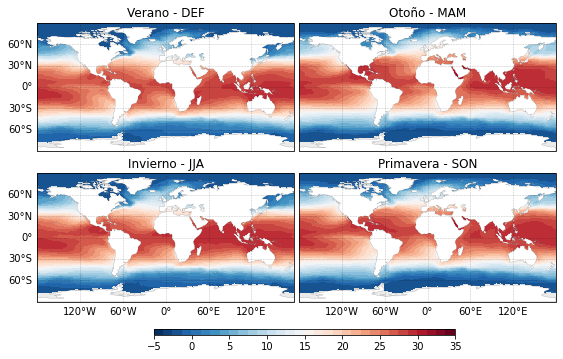

In [24]:
cmap = plt.get_cmap('RdBu_r', (35 - -5)/1.25)
cmap.set_bad('#EBEBEB')

plot = sst_season.sst.plot(x='longitude', y='latitude', col='season', col_wrap=2, figsize = (9,9),
                         subplot_kws = {"projection": projection}, 
                         cmap = cmap, vmin = -5, vmax = 35,
                         cbar_kwargs={'orientation':'horizontal', 'pad':0.05, 'shrink':0.6, 'aspect':50, 'label':''})

for i, ax in enumerate(plot.axes.flatten()):
    ax.add_feature(LAND, edgecolor='black', facecolor = 'white', lw = 0.1, zorder = 1)
    ax.set_title(season[i+1])

    grids = ax.axes.gridlines(color='black', alpha=0.25, linestyle='--', linewidth = 0.5,
                                crs=ccrs.PlateCarree(),
                                draw_labels=True)

    grids.xlabels_top = False; grids.ylabels_right = False    # Desactivar labels innecesarios
    if i not in [0,2]:  grids.ylabels_left = False
    if i in [0,1]:  grids.xlabels_bottom = False

    grids.xlocator = mticker.FixedLocator([-120, -60, 0, 60, 120])  # labels x
    grids.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])    # labels y

    grids.xformatter = LONGITUDE_FORMATTER; grids.yformatter = LATITUDE_FORMATTER

plt.subplots_adjust(bottom = 0.28, top = 0.9, left = 0.1, right = 0.9, wspace = 0.02, hspace = -0.4)

plot.fig.savefig(path + f'SST_Climatology_season_1991-2020.png', 
                 transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

Series de tiempo: anomalías promedio en regiones Niño

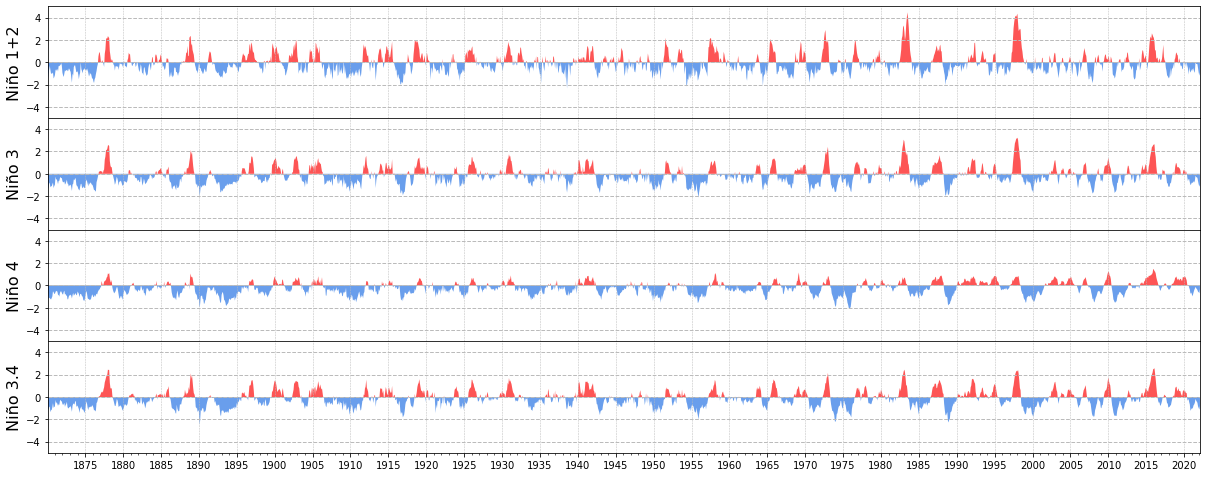

In [25]:
fig, Ax = plt.subplots(4,1, figsize = (20,10), sharex = True)
fig.subplots_adjust(bottom = 0.28, top = 0.9, left = 0.1, right = 0.9, wspace = 0.02, hspace = 0.)

ts_names = {0:'Niño 1+2',1:'Niño 3',2:'Niño 4',3:'Niño 3.4'}
for i, ax in enumerate(Ax.flatten()):
    x = Anom_region.index       # Mensual
    y = Anom_region.iloc[:,i]

    ax.fill_between(x, 0, y, where= y >= 0, facecolor = '#FD5555', interpolate = True)
    ax.fill_between(x, 0, y, where= y < 0, facecolor = '#699EEC', interpolate = True)

    ax.set_ylabel(ts_names[i], fontsize = 16)
    ax.set(ylim=(-5,5))
    ax.margins(x = 0)
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.xaxis.set_minor_locator(mdates.YearLocator(1))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter(''))
    
    ax.yaxis.grid(ls = '--', lw = 1, color = '#BBBBBB', zorder = 1)
    ax.xaxis.grid(ls = '--', lw = 0.5, color = '#BBBBBB', zorder = 1)
    ax.hlines(0, *ax.get_xlim(), ls = '-', lw = 0.5, color = '#BBBBBB', zorder = 1)

fig.savefig(path + f'SST_regiones_M_Niño.png', 
                 transparent = False, pad_inches = 0.1, dpi = 600, bbox_inches = 'tight')

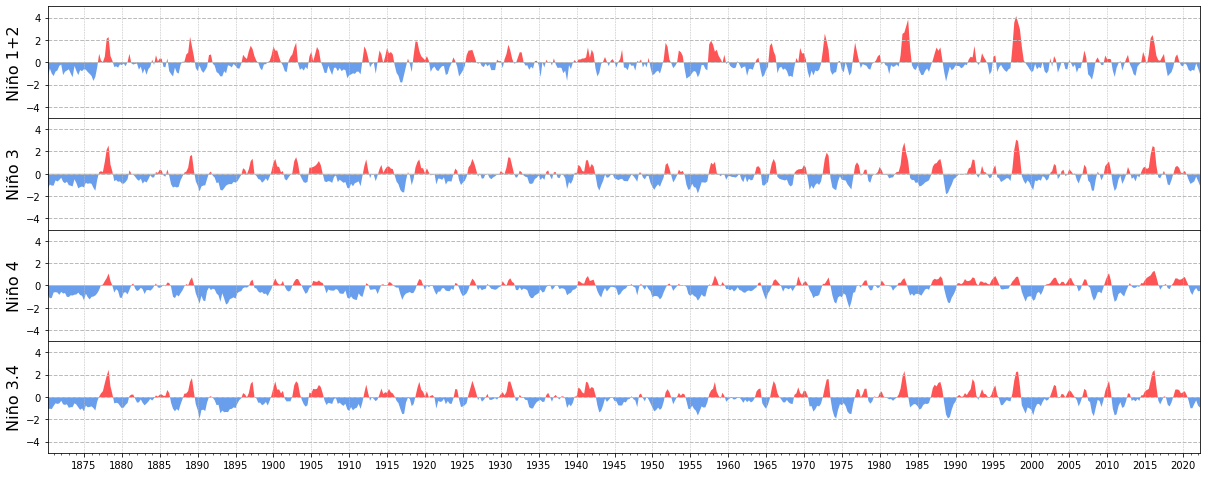

In [26]:
fig, Ax = plt.subplots(4,1, figsize = (20,10), sharex = True)
fig.subplots_adjust(bottom = 0.28, top = 0.9, left = 0.1, right = 0.9, wspace = 0.02, hspace = 0.)

ts_names = {0:'Niño 1+2',1:'Niño 3',2:'Niño 4',3:'Niño 3.4'}
for i, ax in enumerate(Ax.flatten()):
    x = Anom_regionS.index      # Estacional
    y = Anom_regionS.iloc[:,i]

    ax.fill_between(x, 0, y, where= y >= 0, facecolor = '#FD5555', interpolate = True)
    ax.fill_between(x, 0, y, where= y < 0, facecolor = '#699EEC', interpolate = True)

    ax.set_ylabel(ts_names[i], fontsize = 16)
    ax.set(ylim=(-5,5))
    ax.margins(x = 0)
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.xaxis.set_minor_locator(mdates.YearLocator(1))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter(''))
    
    ax.yaxis.grid(ls = '--', lw = 1, color = '#BBBBBB', zorder = 1)
    ax.xaxis.grid(ls = '--', lw = 0.5, color = '#BBBBBB', zorder = 1)
    ax.hlines(0, *ax.get_xlim(), ls = '-', lw = 0.5, color = '#BBBBBB', zorder = 1)

fig.savefig(path + f'SST_regiones_S_Niño.png', 
                 transparent = False, pad_inches = 0.1, dpi = 600, bbox_inches = 'tight')

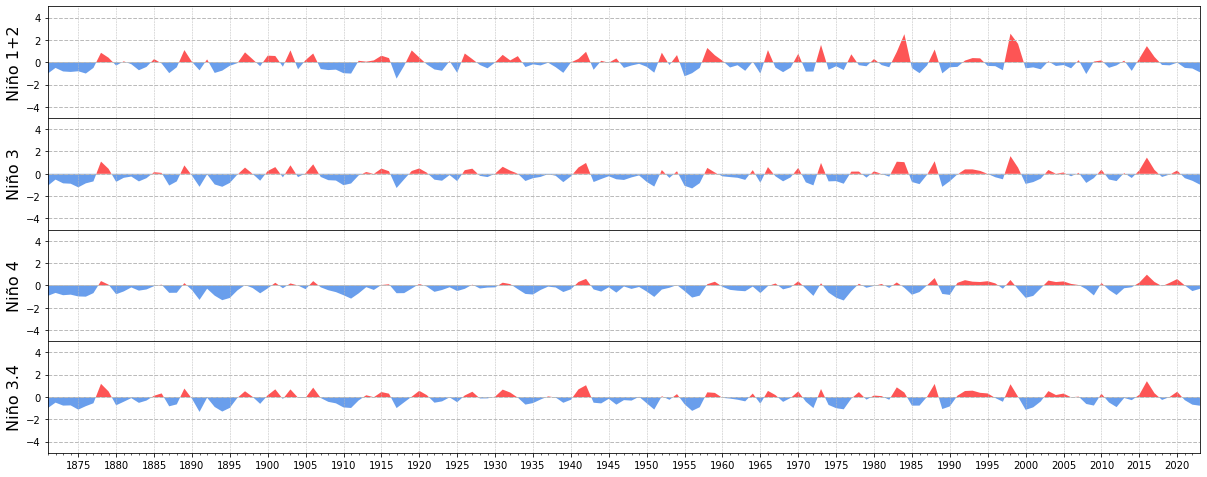

In [27]:
fig, Ax = plt.subplots(4,1, figsize = (20,10), sharex = True)
fig.subplots_adjust(bottom = 0.28, top = 0.9, left = 0.1, right = 0.9, wspace = 0.02, hspace = 0.)

N = 1   # Promedio N-anual
DF = Anom_region.resample(f'{N}Y').mean()

ts_names = {0:'Niño 1+2',1:'Niño 3',2:'Niño 4',3:'Niño 3.4'}
for i, ax in enumerate(Ax.flatten()):
    x = DF.index      # Anual
    y = DF.iloc[:,i]

    ax.fill_between(x, 0, y, where= y >= 0, facecolor = '#FD5555', interpolate = True)
    ax.fill_between(x, 0, y, where= y < 0, facecolor = '#699EEC', interpolate = True)

    ax.set_ylabel(ts_names[i], fontsize = 16)
    ax.set(ylim=(-5,5))
    ax.margins(x = 0)
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.xaxis.set_minor_locator(mdates.YearLocator(1))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter(''))
    
    ax.yaxis.grid(ls = '--', lw = 1, color = '#BBBBBB', zorder = 1)
    ax.xaxis.grid(ls = '--', lw = 0.5, color = '#BBBBBB', zorder = 1)
    ax.hlines(0, *ax.get_xlim(), ls = '-', lw = 0.5, color = '#BBBBBB', zorder = 1)

fig.savefig(path + f'SST_regiones_{N}Y_Niño.png', 
                 transparent = False, pad_inches = 0.1, dpi = 600, bbox_inches = 'tight')

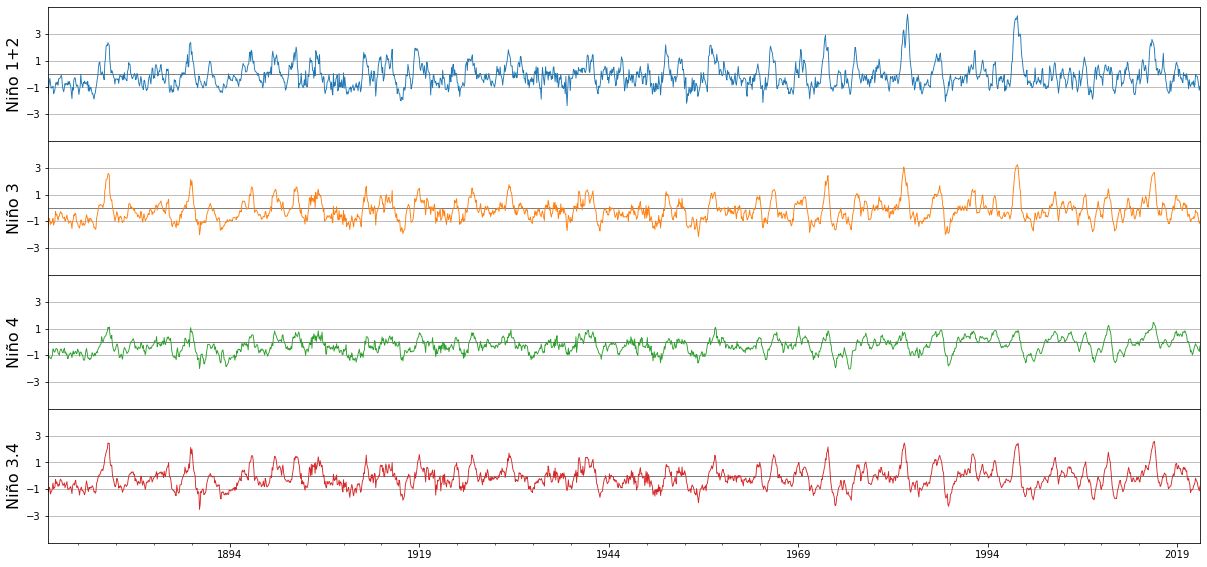

In [28]:
plot = Anom_region.plot(kind = 'line', figsize = (20,12), subplots = True, legend = False,
                        ylim = (-5,5), yticks = range(-3,3+1,2), lw = 0.9)

ts_names = {0:'Niño 1+2',1:'Niño 3',2:'Niño 4',3:'Niño 3.4'}
for i, ax in enumerate(plot.flatten()):
    ax.set_ylabel(ts_names[i], fontsize = 16)
    ax.hlines(0, *ax.get_xlim(), lw = 0.5, zorder = 0)
    ax.yaxis.grid('-')

plt.subplots_adjust(bottom = 0.28, top = 0.9, left = 0.1, right = 0.9, wspace = 0.02, hspace = 0.)
fig = ax.get_figure()
fig.savefig(path + f'SST_regiones_Niño.png', 
                 transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')